In [377]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [378]:
columns = ["engine_id", "time"] + ["operational_setting" + str(i) for i in range(1,4)] + [
"(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

df = pd.read_csv("CMAPSSData/train_FD001.txt", sep = " ", header = None)
df.drop(axis=1, columns=[26, 27], inplace=True) # odrzuć źle wczytane kolumny
df.columns = columns
df

,engine_id,time,operational_setting1,operational_setting2,operational_setting3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [379]:
# full_train_ds['rul'] = full_train_ds.groupby('engine_id')['time'].transform('max') - full_train_ds['time']
df.nunique()

engine_id                                   100
time                                        362
operational_setting1                        158
operational_setting2                         13
operational_setting3                          1
(Fan inlet temperature) (◦R)                  1
(LPC outlet temperature) (◦R)               310
(HPC outlet temperature) (◦R)              3012
(LPT outlet temperature) (◦R)              4051
(Fan inlet Pressure) (psia)                   1
(bypass-duct pressure) (psia)                 2
(HPC outlet pressure) (psia)                513
(Physical fan speed) (rpm)                   53
(Physical core speed) (rpm)                6403
(Engine pressure ratio(P50/P2)                1
(HPC outlet Static pressure) (psia)         159
(Ratio of fuel flow to Ps30) (pps/psia)     427
(Corrected fan speed) (rpm)                  56
(Corrected core speed) (rpm)               6078
(Bypass Ratio)                             1918
(Burner fuel-air ratio)                 

### Drop constant or nearly constant columns


In [380]:
df = df.loc[:, df.nunique() > 13]

### Max cycles histogram


<Axes: >

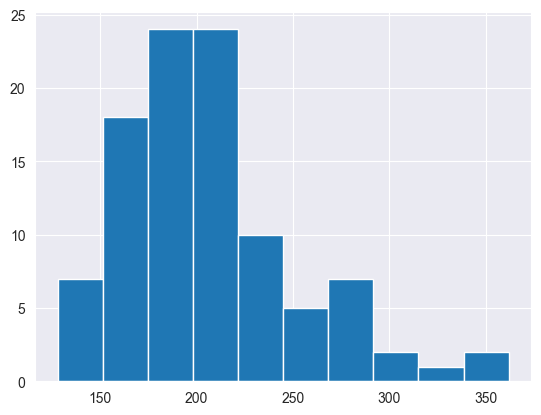

In [381]:
df.groupby(["engine_id"])["time"].max().hist()

### drop outliers

In [382]:
ids_to_drop = df.loc[df['time'] > 300, 'engine_id'].unique()
df = df[~df['engine_id'].isin(ids_to_drop)]

<Axes: >

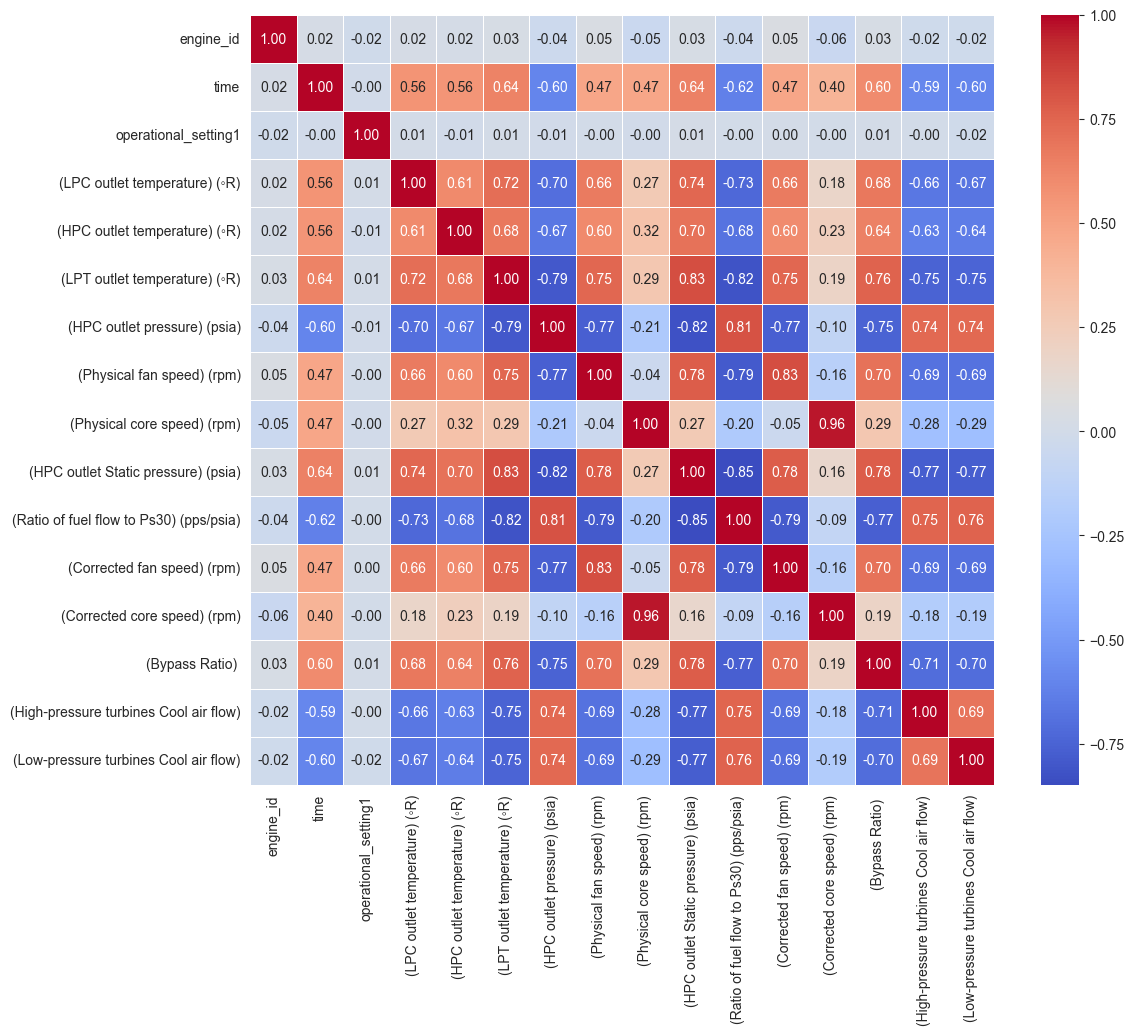

In [383]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [384]:
def draw_time_series(df, engine_id):

    columns_to_smooth = [col for col in df.columns if col not in ['time', 'engine_id']]  # Exclude 'time' column
    filtered_df = df[df['engine_id'] == engine_id]
    df_averaged = filtered_df.copy()
    for col in columns_to_smooth:
        df_averaged[col+" rolling"] = filtered_df[col].rolling(window=window_size, min_periods=1).mean()

    columns_to_plot = [col for col in df_averaged.columns if col not in ['engine_id', 'time'] and "rolling" not in col ]

    num_columns = len(columns_to_plot)
    fig, axes = plt.subplots(nrows=num_columns//2, ncols=2, figsize=(24, num_columns * 2), sharex=True)
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns_to_plot):
        axes[i].plot(df_averaged['time'], df_averaged[column], label=column)
        axes[i].plot(df_averaged['time'], df_averaged[column+" rolling"], label=column + " rolling average")
        axes[i].grid(True)
        axes[i].legend(loc="upper left", fontsize=8)

    axes[-1].set_xlabel("Time")
    fig.suptitle(f"Time series for engine_id {engine_id}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

<Axes: >

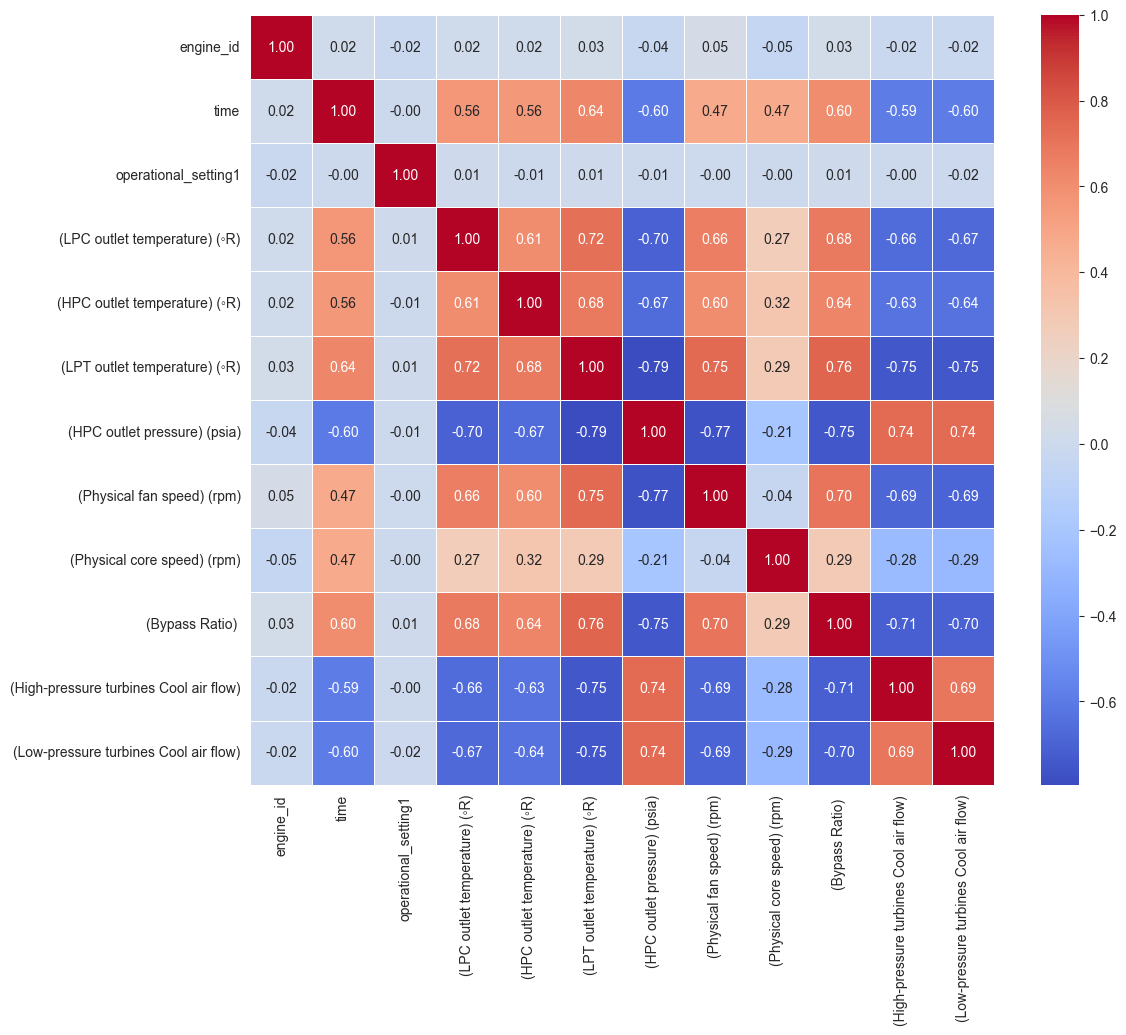

In [385]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features
df.drop(to_drop, axis=1, inplace=True)
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

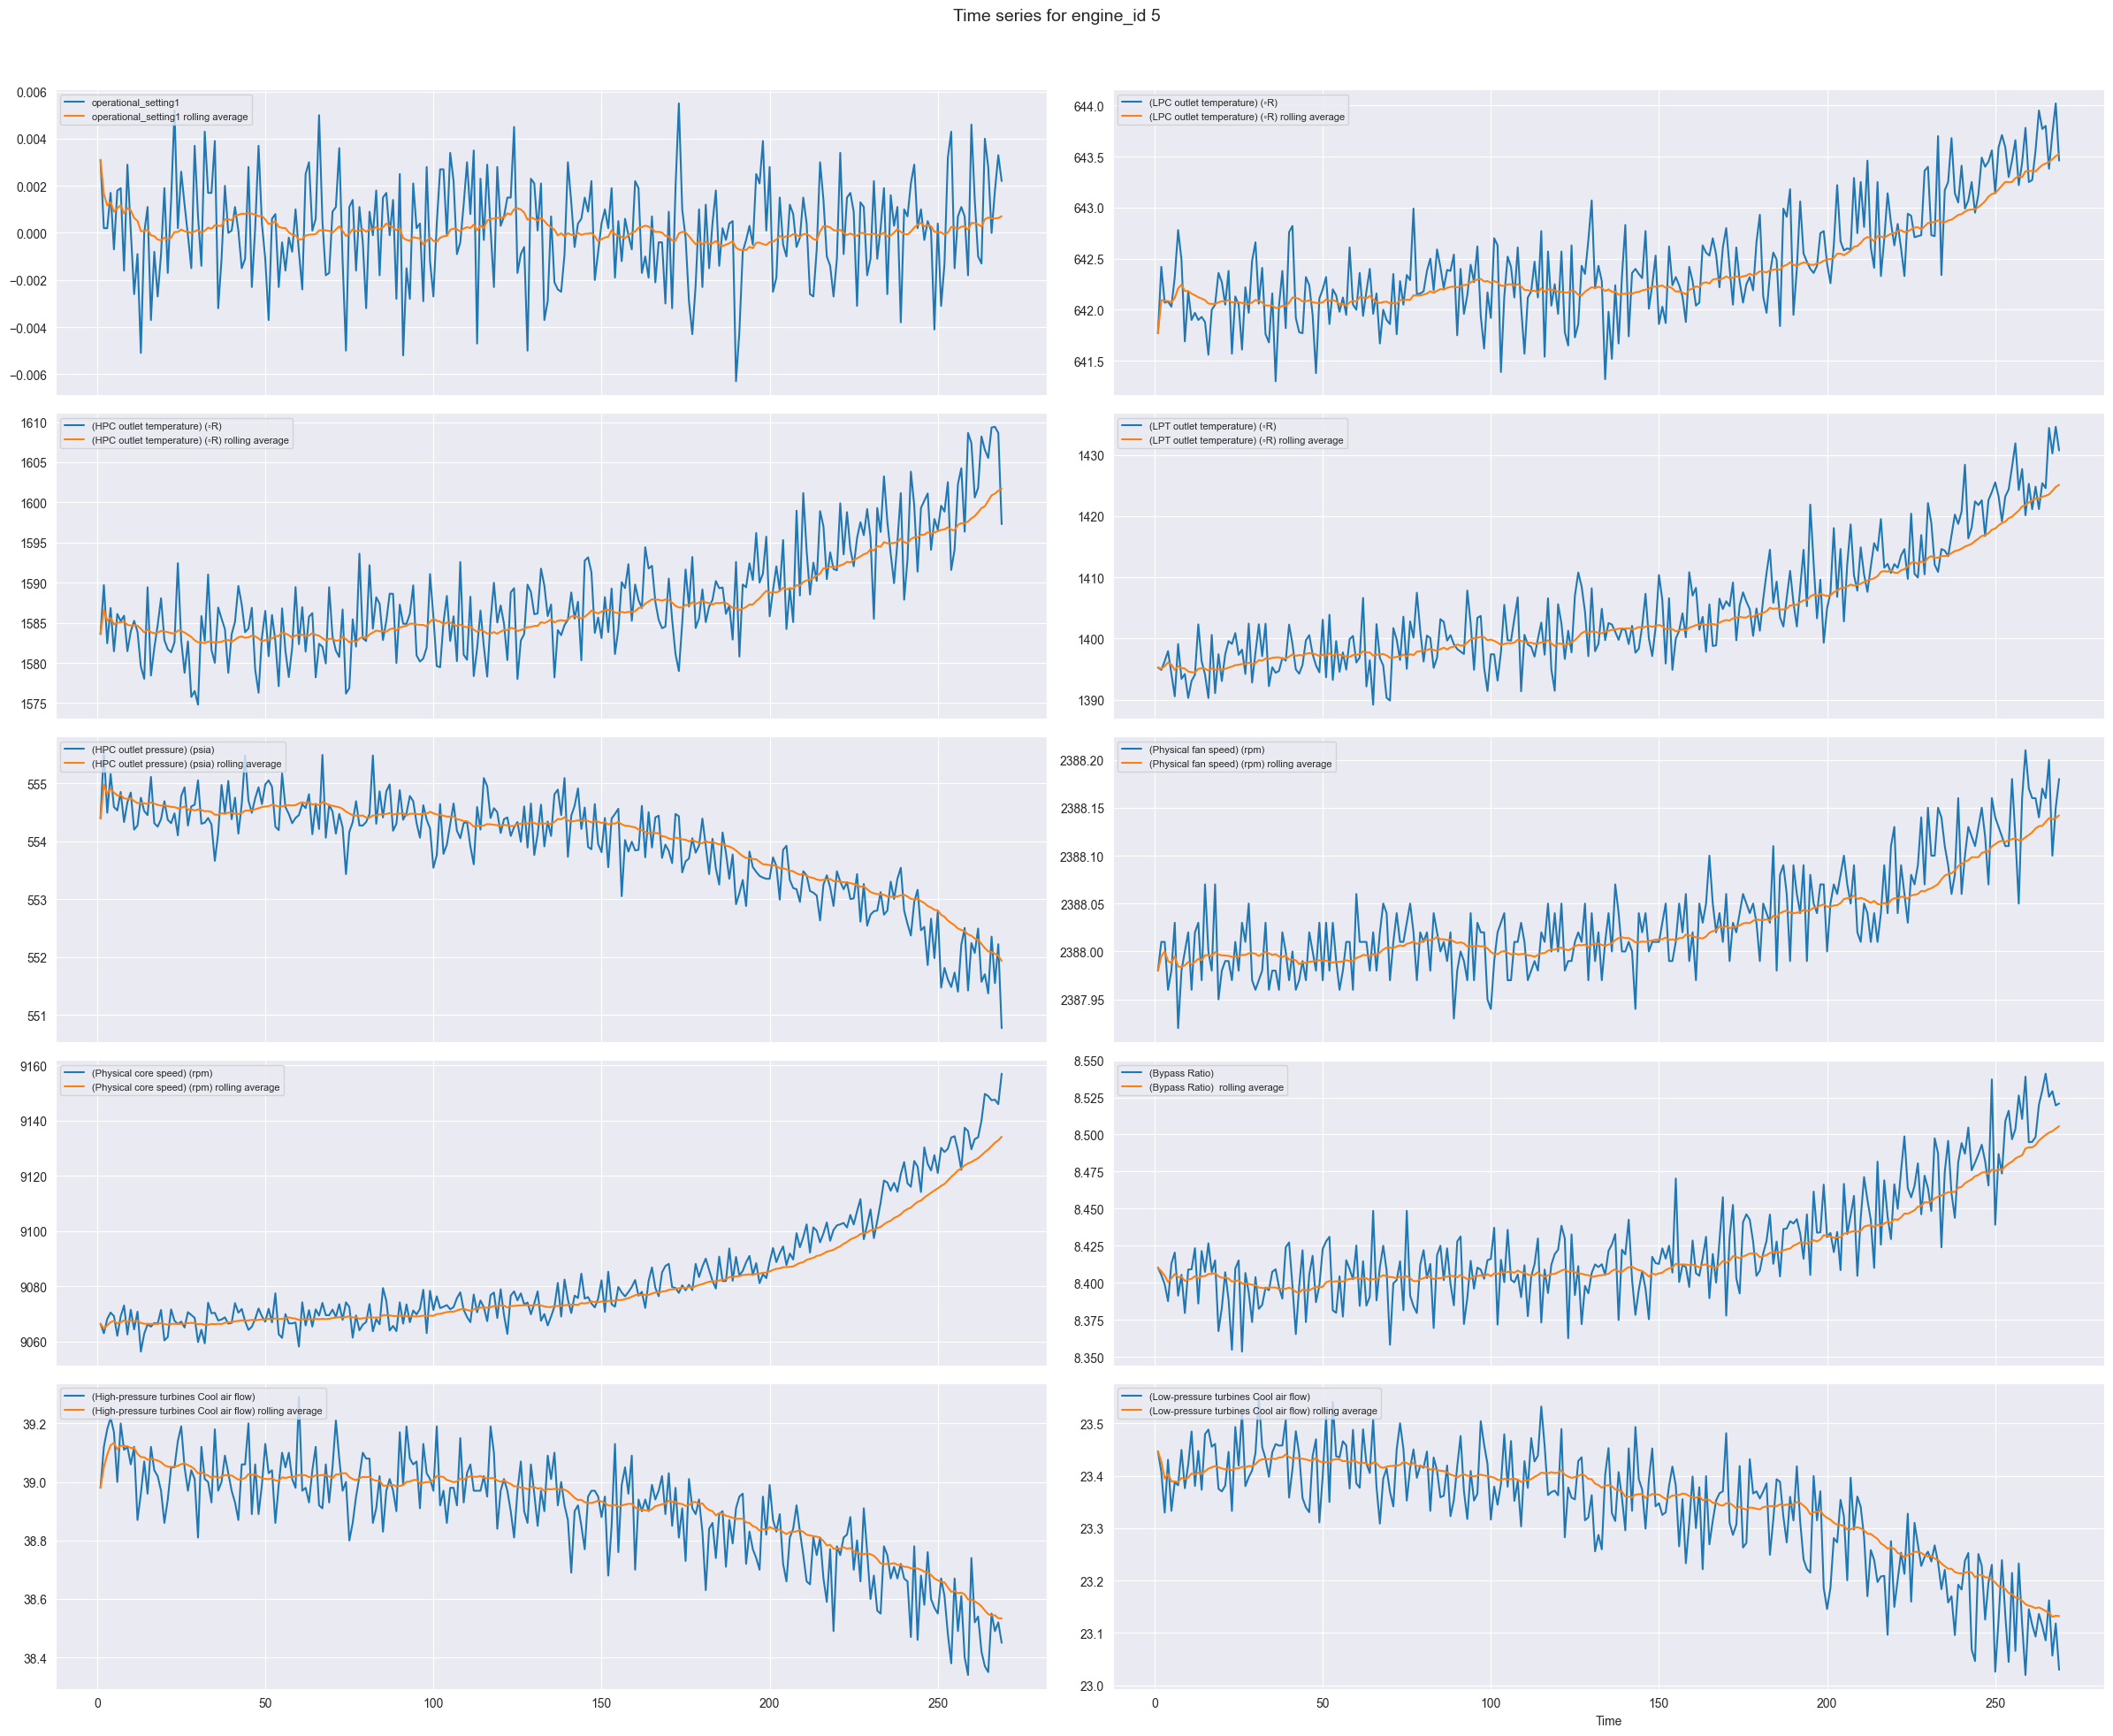

In [386]:
#rolling window size
window_size = 25
engine_id = 5

draw_time_series(df, engine_id)

In [387]:
def draw_time_series_for_all_engines(df):

    columns_to_smooth = [col for col in df.columns if col not in ['time', 'engine_id']]

    for col in columns_to_smooth:
        df[col] = df.groupby('engine_id')[col].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

    averaged_rolling = df.groupby('time')[columns_to_smooth].mean()
    median_rolling = df.groupby('time')[columns_to_smooth].median()

    fig, axes = plt.subplots(nrows=len(columns_to_smooth)//2, ncols=2, figsize=(12, len(columns_to_smooth) * 2), sharex=True)
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns_to_smooth):
        axes[i].plot(averaged_rolling.index, averaged_rolling[column], label=f'Average Rolling mean {column}')
        axes[i].plot(median_rolling.index, median_rolling[column], label=f'Average Rolling median {column}')
        axes[i].set_title(f'Average Rolling mean/median for {column}')
        axes[i].grid(True)
        axes[i].legend(loc="upper left", fontsize=8)

    axes[-1].set_xlabel("Time")
    fig.suptitle(f"Average Rolling mean/average for all Engines", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

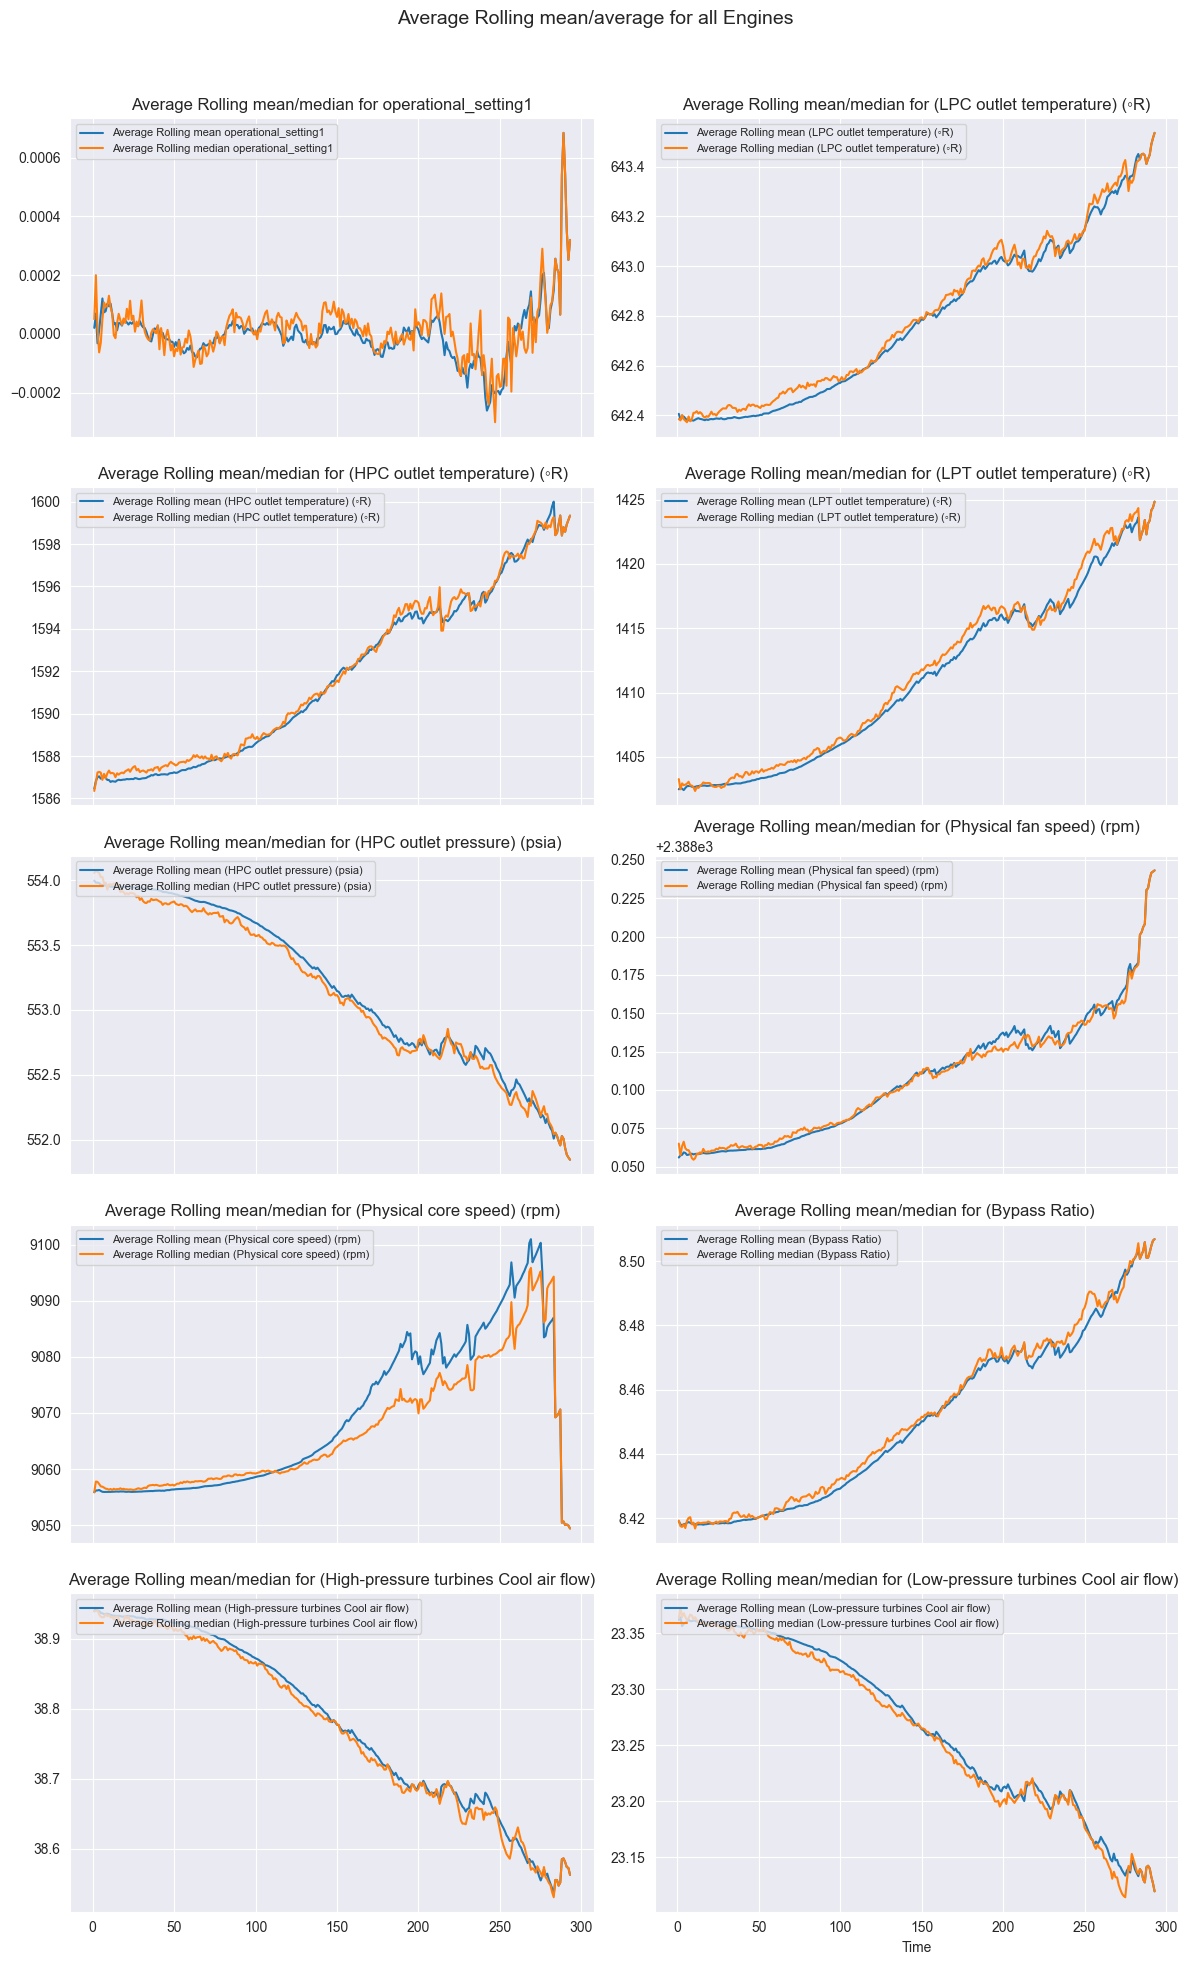

In [388]:
draw_time_series_for_all_engines(df)

### normalizacja

In [417]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = df.copy()
cols = df.columns[df_scaled.columns != "engine_id"]
cols = cols[cols != "time"]
df_scaled[cols] = scaler.fit_transform(df_scaled[cols])

In [419]:
df_scaled[cols]

,operational_setting1,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Bypass Ratio),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,0.458333,0.166727,0.546348,0.331066,0.744949,0.380022,0.093011,0.481143,0.742268,0.745644
1,0.593750,0.241078,0.581068,0.362871,0.667929,0.352877,0.086204,0.514316,0.705449,0.750691
2,0.423611,0.295902,0.550824,0.382320,0.685185,0.380022,0.102922,0.500201,0.672721,0.694290
3,0.468750,0.323315,0.493122,0.377458,0.705808,0.413952,0.105726,0.426259,0.634880,0.682384
4,0.441667,0.341565,0.458893,0.396328,0.695455,0.407166,0.114691,0.447916,0.617084,0.688627
...,...,...,...,...,...,...,...,...,...,...
20626,0.532083,0.856705,0.848582,0.892707,0.108081,0.783931,0.224762,0.923708,0.055965,0.101927
20627,0.540833,0.866979,0.851399,0.901371,0.093939,0.789359,0.223983,0.927354,0.046637,0.099048
20628,0.540000,0.867340,0.860478,0.910938,0.080202,0.791531,0.224006,0.944399,0.047619,0.077452
20629,0.530833,0.873107,0.864435,0.911949,0.064646,0.801303,0.227204,0.953008,0.022582,0.067410
